 # Testing with Oceananigans

In [1]:
using JLD2
using Plots

In [2]:
# Parameters
Lx = 64
Lz = 64;

In [3]:
using Oceananigans, Oceananigans.Advection, Oceananigans.Fields, Oceananigans.Grids

grid = RegularCartesianGrid(size=(Lx, 1, Lz), extent=(2π, 2π, 2π))

RegularCartesianGrid{Float64, Periodic, Periodic, Bounded}
                   domain: x ∈ [0.0, 6.283185307179586], y ∈ [0.0, 6.283185307179586], z ∈ [-6.283185307179586, 5.517472001167444e-16]
                 topology: (Periodic, Periodic, Bounded)
  resolution (Nx, Ny, Nz): (64, 1, 64)
   halo size (Hx, Hy, Hz): (1, 1, 1)
grid spacing (Δx, Δy, Δz): (0.09817477042468103, 6.283185307179586, 0.09817477042468103)

In [4]:
model = IncompressibleModel(timestepper = :RungeKutta3,
                              advection = WENO5(),
                                   grid = grid,
                               buoyancy = BuoyancyTracer(),
                                tracers = :b,
                                closure = IsotropicDiffusivity(ν=2e-4, κ=2e-4)
                           )

IncompressibleModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularCartesianGrid{Float64, Periodic, Periodic, Bounded}(Nx=64, Ny=1, Nz=64)
├── tracers: (:b,)
├── closure: IsotropicDiffusivity{Float64,NamedTuple{(:b,),Tuple{Float64}}}
├── buoyancy: BuoyancyTracer
└── coriolis: Nothing

In [5]:
height = 1.0;
width = 0.5;

#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * (1.0 - tanh(abs(z+2*π)/height));
#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * -(1.0 - tanh(abs(z+0*π)/height));
initial_buoyancy(x,y,z) = 0.1*(width>sqrt((x-0.5)^2 + (z+2π-height)^2))

set!(model, b=initial_buoyancy)

In [6]:
# simplify the notation by "unpacking" u, v and w from 'model.velocities' and b from model.tracers

u, v, w = model.velocities
b = model.tracers.b

Field located at (Cell, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (70, 7, 70)
├── grid: RegularCartesianGrid{Float64, Periodic, Periodic, Bounded}(Nx=64, Ny=1, Nz=64)
└── boundary conditions: x=(west=Periodic, east=Periodic), y=(south=Periodic, north=Periodic), z=(bottom=ZeroFlux, top=ZeroFlux)

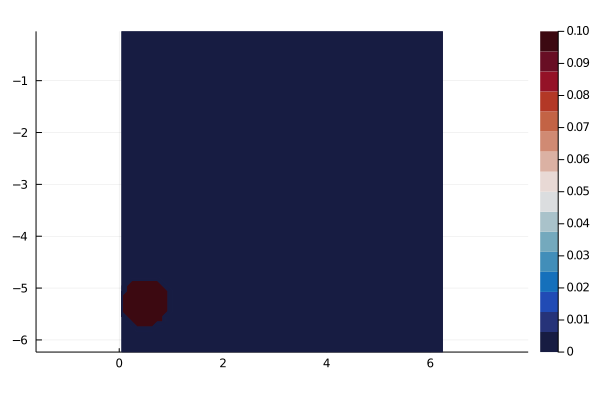

In [7]:
xb, yb, zb = nodes(b)
contourf(xb,zb,b[1:64,1,1:64]',color=:balance, aspect_ratio=:equal)

In [8]:
# Now we construct a simulation that prints out the iteration and model time as it runs.

progress(sim) = @info "Iteration: $(sim.model.clock.iteration), time: $(round(Int, sim.model.clock.time))"

simulation = Simulation(model, Δt=0.2, stop_time=40.0, iteration_interval=20, progress=progress);



In [9]:
# Output
#
# We set up an output writer for the simulation that saves the vorticity every 1 seconds (50 iterations).


using Oceananigans.OutputWriters

simulation.output_writers[:fields] = JLD2OutputWriter(model, (b=b,u=u,w=w),
                                                      schedule = TimeInterval(1.0),
                                                      prefix = "gravity_current",
                                                      force = true);
                  

In [10]:
#  Running the simulation

run!(simulation)

┌ Info: Iteration: 20, time: 4
└ @ Main In[8]:3
┌ Info: Iteration: 40, time: 8
└ @ Main In[8]:3
┌ Info: Iteration: 60, time: 12
└ @ Main In[8]:3
┌ Info: Iteration: 80, time: 16
└ @ Main In[8]:3
┌ Info: Iteration: 100, time: 20
└ @ Main In[8]:3
┌ Info: Iteration: 120, time: 24
└ @ Main In[8]:3
┌ Info: Iteration: 140, time: 28
└ @ Main In[8]:3
┌ Info: Iteration: 160, time: 32
└ @ Main In[8]:3
┌ Info: Iteration: 180, time: 36
└ @ Main In[8]:3
┌ Info: Iteration: 200, time: 40
└ @ Main In[8]:3
┌ Info: Simulation is stopping. Model time 40.000 seconds has hit or exceeded simulation stop time 40 seconds.
└ @ Oceananigans.Simulations /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/Simulations/run.jl:40


In [11]:
# We load the output.
using JLD2
file = jldopen(simulation.output_writers[:fields].filepath)
iterations = parse.(Int, keys(file["timeseries/t"]));

┌ Info: Saved animation to 
│   fn = /Users/williamdavis/Dropbox/viscosometry/code/tmp.gif
└ @ Plots /Users/williamdavis/.julia/packages/Plots/w4QRq/src/animation.jl:104


Plots.AnimatedGif("/Users/williamdavis/Dropbox/viscosometry/code/tmp.gif")
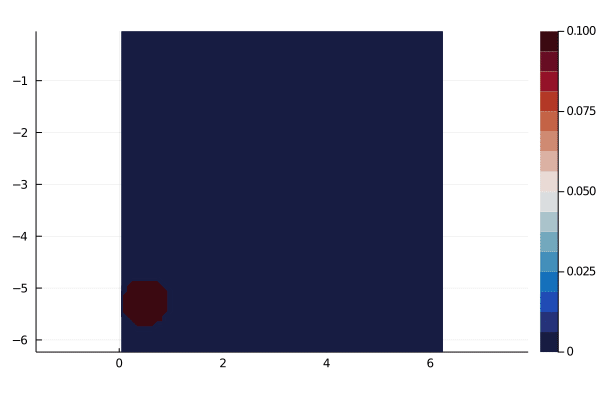

In [12]:
# Plot buoyancy

@gif for (i, iter) in enumerate(iterations)
    # retrieve solution from JLD2 file

    #t = file["timeseries/t/$iter"]
    b_snapshot = file["timeseries/b/$iter"][:, 1, :]

    contourf(xb, zb, b_snapshot',color=:balance, aspect_ratio=:equal) # , clim=(0,0.1)
end
#gif(anim, "buoy_anim_fps15.gif", fps = 15)

# Testing 2D version

Periodic in 3rd dimension

In [122]:
Ly, Lz = 64, 64
grid2D = RegularCartesianGrid(topology = (Periodic, Bounded, Bounded),
                              size=(1, Ly, Lz), 
                              extent=(2π, 2π, 2π))

RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}
                   domain: x ∈ [0.0, 6.283185307179586], y ∈ [8.410780489584512e-18, 6.283185307179587], z ∈ [-6.283185307179586, 5.517472001167444e-16]
                 topology: (Periodic, Bounded, Bounded)
  resolution (Nx, Ny, Nz): (1, 64, 64)
   halo size (Hx, Hy, Hz): (1, 1, 1)
grid spacing (Δx, Δy, Δz): (6.283185307179586, 0.09817477042468103, 0.09817477042468103)

In [123]:
v_bcs = VVelocityBoundaryConditions(grid2D,
           top = ValueBoundaryCondition(0.0),
        bottom = ValueBoundaryCondition(0.0))

w_bcs = WVelocityBoundaryConditions(grid2D,
        north = ValueBoundaryCondition(0.0),
        south = ValueBoundaryCondition(0.0))

Oceananigans.FieldBoundaryConditions (NamedTuple{(:x, :y, :z)}), with boundary conditions
├── x: CoordinateBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic,Nothing},BoundaryCondition{Oceananigans.BoundaryConditions.Periodic,Nothing}}
├── y: CoordinateBoundaryConditions{BoundaryCondition{Value,Float64},BoundaryCondition{Value,Float64}}
└── z: CoordinateBoundaryConditions{BoundaryCondition{NormalFlow,Nothing},BoundaryCondition{NormalFlow,Nothing}}

In [124]:
model2D = IncompressibleModel(timestepper = :RungeKutta3,
                              advection = WENO5(),
                                   grid = grid2D,
                               buoyancy = BuoyancyTracer(),
                                tracers = :b,
                    boundary_conditions = (v=v_bcs, w=w_bcs),
                                closure = IsotropicDiffusivity(ν=2e-4, κ=2e-4))

IncompressibleModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}(Nx=1, Ny=64, Nz=64)
├── tracers: (:b,)
├── closure: IsotropicDiffusivity{Float64,NamedTuple{(:b,),Tuple{Float64}}}
├── buoyancy: BuoyancyTracer
└── coriolis: Nothing

In [125]:
height = 1.0;
width = 0.5;

#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * (1.0 - tanh(abs(z+2*π)/height));
#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * -(1.0 - tanh(abs(z+0*π)/height));
initial_buoyancy(x,y,z) = 0.1*(width>sqrt((y-0.5)^2 + (z+2π-height)^2))

set!(model2D, b=initial_buoyancy)


In [126]:
u, v, w = model2D.velocities
b = model2D.tracers.b

Field located at (Cell, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (7, 70, 70)
├── grid: RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}(Nx=1, Ny=64, Nz=64)
└── boundary conditions: x=(west=Periodic, east=Periodic), y=(south=ZeroFlux, north=ZeroFlux), z=(bottom=ZeroFlux, top=ZeroFlux)

In [127]:
using Oceananigans.AbstractOperations
s = sqrt(v^2 + w^2)

s_field = ComputedField(s)

ω = ∂y(w) - ∂z(v)

ω_field = ComputedField(ω)

ComputedField located at (Cell, Face, Face) of BinaryOperation at (Cell, Face, Face)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (7, 71, 71)
├── grid: RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}(Nx=1, Ny=64, Nz=64)
├── operand: BinaryOperation at (Cell, Face, Face)
└── status: time=0.0


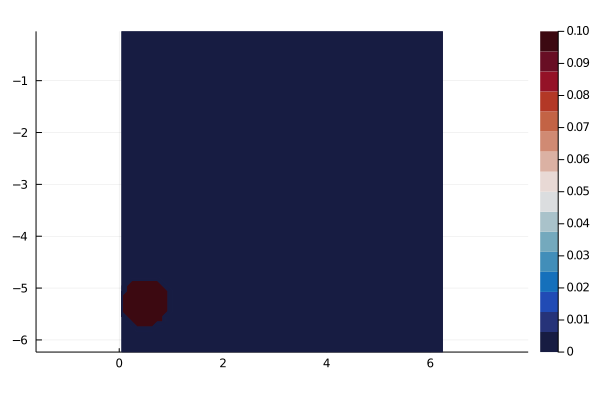

In [128]:
xb, yb, zb = nodes(b)
contourf(yb,zb,b[1,1:64,1:64]',color=:balance, aspect_ratio=:equal)

In [129]:
simulation = Simulation(model2D, Δt=0.2, 
    stop_time=40.0, iteration_interval=20, progress=progress);

using Oceananigans.OutputWriters

simulation.output_writers[:fields] = 
        JLD2OutputWriter(model2D, 
                         (b=b,v=v,w=w,ω=ω_field, s=s_field),
                          schedule = TimeInterval(1.0),
                          prefix = "gravity_current",
                          force = true);

In [130]:
run!(simulation)

┌ Info: Iteration: 20, time: 4
└ @ Main In[8]:3
┌ Info: Iteration: 40, time: 8
└ @ Main In[8]:3
┌ Info: Iteration: 60, time: 12
└ @ Main In[8]:3
┌ Info: Iteration: 80, time: 16
└ @ Main In[8]:3
┌ Info: Iteration: 100, time: 20
└ @ Main In[8]:3
┌ Info: Iteration: 120, time: 24
└ @ Main In[8]:3
┌ Info: Iteration: 140, time: 28
└ @ Main In[8]:3
┌ Info: Iteration: 160, time: 32
└ @ Main In[8]:3
┌ Info: Iteration: 180, time: 36
└ @ Main In[8]:3
┌ Info: Iteration: 200, time: 40
└ @ Main In[8]:3
┌ Info: Simulation is stopping. Model time 40.000 seconds has hit or exceeded simulation stop time 40 seconds.
└ @ Oceananigans.Simulations /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/Simulations/run.jl:40


┌ Info: Saved animation to 
│   fn = /Users/williamdavis/Dropbox/viscosometry/code/tmp.gif
└ @ Plots /Users/williamdavis/.julia/packages/Plots/w4QRq/src/animation.jl:104


Plots.AnimatedGif("/Users/williamdavis/Dropbox/viscosometry/code/tmp.gif")
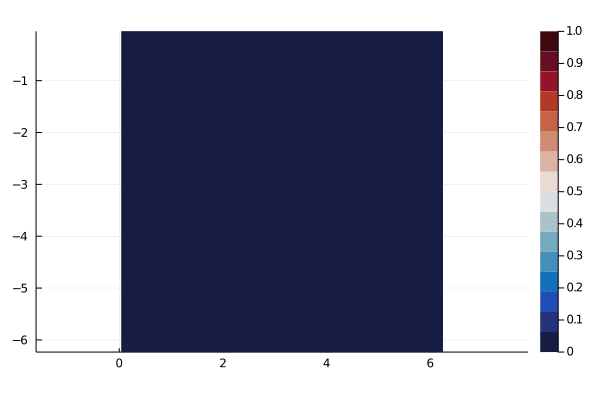

In [135]:
file = jldopen(simulation.output_writers[:fields].filepath)
iterations = parse.(Int, keys(file["timeseries/t"]));
# Plot buoyancy

@gif for iter in iterations
    # retrieve solution from JLD2 file

    #t = file["timeseries/t/$iter"]
    #b_snapshot = file["timeseries/b/$iter"][1, :, :]
    #b_snapshot = file["timeseries/v/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/w/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/ω/$iter"][1, 1:64, 1:64]
    b_snapshot = file["timeseries/s/$iter"][1, 1:64, 1:64]

    contourf(yb, zb, b_snapshot',color=:balance, aspect_ratio=:equal) # , clim=(0,0.1)
end
#gif(anim, "buoy_anim_fps15.gif", fps = 15)

# Trying true 2D

In [24]:
grid2Dtrue = RegularCartesianGrid(topology = (Flat, Bounded, Bounded),
                              size=(64, 64), 
                              extent=(2π, 2π))

RegularCartesianGrid{Float64, Flat, Bounded, Bounded}
                   domain: x ∈ [0.0, 0.0], y ∈ [8.410780489584512e-18, 6.283185307179587], z ∈ [-6.283185307179586, 5.517472001167444e-16]
                 topology: (Flat, Bounded, Bounded)
  resolution (Nx, Ny, Nz): (1, 64, 64)
   halo size (Hx, Hy, Hz): (0, 1, 1)
grid spacing (Δx, Δy, Δz): (0.0, 0.09817477042468103, 0.09817477042468103)

In [25]:
v_bcs = VVelocityBoundaryConditions(grid2Dtrue,
           top = ValueBoundaryCondition(0.0),
        bottom = ValueBoundaryCondition(0.0))

w_bcs = WVelocityBoundaryConditions(grid2Dtrue,
        north = ValueBoundaryCondition(0.0),
        south = ValueBoundaryCondition(0.0))

T_bcs = TracerBoundaryConditions(grid2Dtrue,
          top = ValueBoundaryCondition(0.0),
       bottom = GradientBoundaryCondition(0.0));

In [26]:
model2Dtrue = IncompressibleModel(grid = grid2Dtrue,
                            #timestepper = :RungeKutta3,
                             # advection = WENO5(),
                               buoyancy = BuoyancyTracer(),
                                tracers = :b,
                    boundary_conditions = (v=v_bcs, w=w_bcs, T=T_bcs),
                                #closure = IsotropicDiffusivity(ν=2e-4, κ=2e-4)
                           )

IncompressibleModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularCartesianGrid{Float64, Flat, Bounded, Bounded}(Nx=1, Ny=64, Nz=64)
├── tracers: (:b,)
├── closure: IsotropicDiffusivity{Float64,NamedTuple{(:b,),Tuple{Float64}}}
├── buoyancy: BuoyancyTracer
└── coriolis: Nothing

In [27]:
height = 1.0;
width = 0.5;

#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * (1.0 - tanh(abs(z+2*π)/height));
#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * -(1.0 - tanh(abs(z+0*π)/height));
initial_buoyancy(x,y,z) = 0.1*(width>sqrt((y-π)^2 + (z+2π-height)^2))

set!(model2Dtrue, b=initial_buoyancy)



In [28]:
model2Dtrue.velocities

MethodError: MethodError: no method matching bctype_str(::Nothing)
Closest candidates are:
  bctype_str(!Matched::BoundaryCondition{Flux,Nothing}) at /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/BoundaryConditions/show_boundary_conditions.jl:29
  bctype_str(!Matched::BoundaryCondition{var"#s63",T} where T where var"#s63"<:Flux) at /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/BoundaryConditions/show_boundary_conditions.jl:24
  bctype_str(!Matched::BoundaryCondition{var"#s63",T} where T where var"#s63"<:Oceananigans.BoundaryConditions.Periodic) at /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/BoundaryConditions/show_boundary_conditions.jl:25
  ...

In [29]:
u, v, w = model2Dtrue.velocities
b = model2Dtrue.tracers.b

MethodError: MethodError: no method matching bctype_str(::Nothing)
Closest candidates are:
  bctype_str(!Matched::BoundaryCondition{Flux,Nothing}) at /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/BoundaryConditions/show_boundary_conditions.jl:29
  bctype_str(!Matched::BoundaryCondition{var"#s63",T} where T where var"#s63"<:Flux) at /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/BoundaryConditions/show_boundary_conditions.jl:24
  bctype_str(!Matched::BoundaryCondition{var"#s63",T} where T where var"#s63"<:Oceananigans.BoundaryConditions.Periodic) at /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/BoundaryConditions/show_boundary_conditions.jl:25
  ...

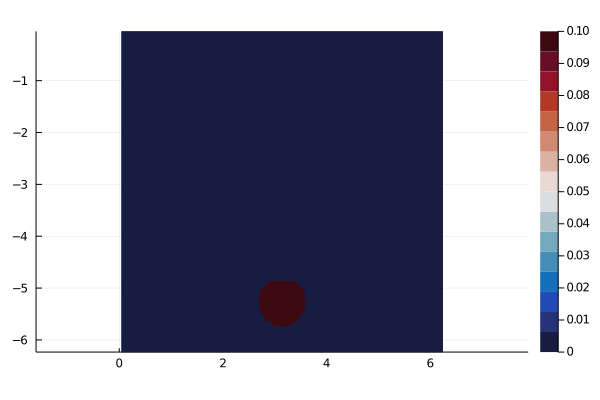

In [30]:
xb, yb, zb = nodes(b)
contourf(yb,zb,b[1,1:64,1:64]',color=:balance, aspect_ratio=:equal)